# Decoding movie features from (V1) visual cortex

- this notebook will demo how to use CEBRA on the allen data (shown in Fig. 4, 5).

- Install note: be sure you have cebra, and the demo dependencies, installed to use this notebook: 

In [ ]:
!pip install 'cebra[datasets,demos]'

In [125]:
import sys

import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib as jl
import torch
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
import cebra.datasets
from cebra import CEBRA
import cebra


In [204]:
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

- Be sure you have downloaded the data and placed `/data` from [FigShare](https://figshare.com/s/60adb075234c2cc51fa3) and into the `demo_notebooks` directory. Let's check if it's there:

In [1]:
ls

Demo_Allen.ipynb                      Demo_learnable_temperature.ipynb
Demo_cohomology.ipynb                 Demo_primate_reaching.ipynb
Demo_consistency.ipynb                Demo_primate_reaching_mse_loss.ipynb
Demo_conv-pivae.ipynb                 Demo_synthetic_exp.ipynb
Demo_decoding.ipynb                   README.rst
Demo_hippocampus.ipynb                data/
Demo_hippocampus_multisession.ipynb   rat_demo_example_output.h5
Demo_hypothesis_testing.ipynb


## Load the data

- In this example, we load Ca (30 Hz) and Neuropixels (120Hz) recording from pseudomice (stacked neurons from multiple mice), recorded while the Natural Movie1 stimulus (30sec, 30Hz) was passively shown during 10 repeats. 
- Pre-defined CEBRA datasets used for the paper experiments include varied dataset with different "cortex", "seed" and "num_neurons".

- Set "cortex" from ["VISp", "VISpm", "VISam", "VISrl", "VISal", "VISl"], "seed" from [111, 222, 333, 444, 555] and "num_neurons" from [10, 30, 50, 100, 200, 400, 600, 800, 900, 1000]. 

In [158]:
cortex = 'VISp'
seed=333
num_neurons = 800

ca_train = cebra.datasets.init(f'allen-movie-one-ca-{cortex}-{num_neurons}-train-10-{seed}')
np_train = cebra.datasets.init(f'allen-movie-one-neuropixel-{cortex}-{num_neurons}-train-10-{seed}')
joint_train = cebra.datasets.init(f'allen-movie-one-ca-neuropixel-{cortex}-{num_neurons}-train-10-{seed}')

ca_test = cebra.datasets.init(f'allen-movie-one-ca-{cortex}-{num_neurons}-test-10-{seed}')
np_test = cebra.datasets.init(f'allen-movie-one-neuropixel-{cortex}-{num_neurons}-test-10-{seed}')
joint_test = cebra.datasets.init(f'allen-movie-one-ca-neuropixel-{cortex}-{num_neurons}-test-10-{seed}')


Text(0.5, 1.0, 'Neuropixels')

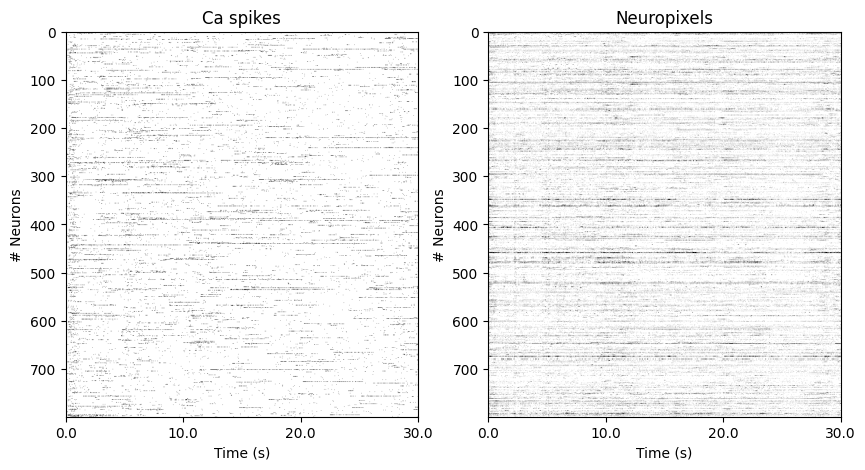

In [329]:
plt.figure(figsize=(10,5))
ax1= plt.subplot(1,2,1)
ax1.imshow(ca_train.neural.cpu().numpy()[:900].T, aspect = 'auto', vmax = 1, vmin = 0, cmap ='gray_r')
ax1.set_ylabel('# Neurons')
ax1.set_xlabel('Time (s)')
ax1.set_xticks(np.linspace(0,900, 4))
ax1.set_xticklabels(np.linspace(0,30, 4))
ax1.set_title('Ca spikes')
ax2= plt.subplot(1,2,2)
ax2.imshow(np_train.neural.cpu().numpy()[:3600].T, aspect = 'auto', vmax = 1, vmin = 0, cmap ='gray_r')
ax2.set_ylabel('# Neurons')
ax2.set_xlabel('Time (s)')
ax2.set_xticks(np.linspace(0,3600, 4))
ax2.set_xticklabels(np.linspace(0,30, 4))
ax2.set_title('Neuropixels')

## Visualize DINO features of the video frames

- CEBRA datasets include the video frames (Natural movie 1 from Allen Visual Coding) features extracted from a vision transformer model, DINO(https://arxiv.org/abs/2104.14294).
- Here we visualize DINO features using 2D tSNE. 

/data/cebra/anaconda3/envs/nlb/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/data/cebra/anaconda3/envs/nlb/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(-43.977273559570314,
 50.246514892578126,
 -47.49126300811768,
 57.91667423248291)

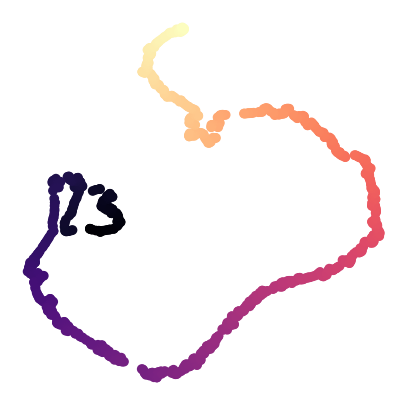

In [159]:
dino_tsne = TSNE(n_components = 2)
dino_tsne_viz = dino_tsne.fit_transform(ca_train.index[:900,:])

fig = plt.figure(figsize = (5,5))
plt.scatter(dino_tsne_viz[:,0], dino_tsne_viz[:,1], cmap = 'magma', c = np.arange(900))
plt.axis('off')

## Train CEBRA models (Ca, Neuropixel, 1 frame window) using DINO features as behavior labels

- We train CEBRA-Behavior models using the DINO video frames features as behavior labels on Ca recording, ephys recording.


In [160]:
## Helper functions to define CEBRA solvers

def single_session_solver(data_loader, **kwargs):
    """Train a single session CEBRA model."""
    norm = True
    if kwargs['distance'] == 'euclidean':
        norm = False
    data_loader.to(kwargs['device'])
    model = cebra.models.init(kwargs['model_architecture'], data_loader.dataset.input_dimension,
                              kwargs['num_hidden_units'],
                              kwargs['output_dimension'], norm).to(kwargs['device'])
    data_loader.dataset.configure_for(model)
    if kwargs['distance'] == 'euclidean':
        criterion = cebra.models.InfoMSE(temperature=kwargs['temperature'])
    elif kwargs['distance'] == 'cosine':        
        criterion = cebra.models.InfoNCE(temperature=kwargs['temperature'])
    optimizer = torch.optim.Adam(itertools.chain(model.parameters(), criterion.parameters()), lr=kwargs['learning_rate'])
    return cebra.solver.SingleSessionSolver(model=model,
                                            criterion=criterion,
                                            optimizer=optimizer,
                                            tqdm_on=kwargs['verbose'])

def multi_session_solver(data_loader, **kwargs):
    norm = True
    if kwargs['distance'] == 'euclidean':
        norm = False
    for dataset in data_loader.dataset.iter_sessions():
        dataset.to(kwargs['device'])
        
    model = torch.nn.ModuleList([
        cebra.models.init(m, dataset.input_dimension,
                          kwargs['num_hidden_units'], kwargs['output_dimension'], norm)
        for dataset, m in zip(data_loader.dataset.iter_sessions(), kwargs['model_architecture'])
    ]).to(kwargs['device'])
    
    for m in model:
        m.to(kwargs['device'])
    for n, dataset in enumerate(data_loader.dataset.iter_sessions()):
        dataset.configure_for(model[n])
    if kwargs['distance'] == 'euclidean':
        criterion = cebra.models.InfoMSE(temperature=kwargs['temperature'])
    elif kwargs['distance'] == 'cosine':        
        criterion = cebra.models.InfoNCE(temperature=kwargs['temperature'])
    optimizer = torch.optim.Adam(itertools.chain(model.parameters(), criterion.parameters()), lr=kwargs['learning_rate'])
    return cebra.solver.MultiSessionSolver(model=model,
                                           criterion=criterion,
                                           optimizer=optimizer,
                                           tqdm_on=kwargs['verbose'])

@torch.no_grad()
def get_emissions(model, dataset):
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    model.to(device)
    dataset.configure_for(model)
    return model(dataset[torch.arange(len(dataset))].to(device)).cpu().numpy()

def _compute_emissions_single(solver, dataset):
    return get_emissions(solver.model, dataset)

def _compute_emissions_multi(solver, dataset):

    return {
        i :
            get_emissions(model, session)
            for i, (model, session) in enumerate(zip(solver.model, dataset.iter_sessions()))
    }

In [161]:
train_steps = 10000

In [162]:
ca_loader = cebra.data.ContinuousDataLoader(ca_train, num_steps = train_steps, batch_size = 512, conditional = 'time_delta', time_offset =1)
np_loader = cebra.data.ContinuousDataLoader(np_train, num_steps = train_steps, batch_size = 512, conditional = 'time_delta', time_offset = 1)

In [163]:
cebra_ca = single_session_solver(data_loader = ca_loader, model_architecture = 'offset1-model', 
                 distance = 'cosine', num_hidden_units = 128, output_dimension = 128,
                verbose = True, device = DEVICE, temperature = 1, learning_rate = 3e-4)

cebra_np = single_session_solver(data_loader = np_loader, model_architecture = 'resample1-model', 
                 distance = 'cosine', num_hidden_units = 128, output_dimension = 128,
                verbose = True, device = DEVICE, temperature = 1, learning_rate = 3e-4)

In [164]:
cebra_ca.fit(ca_loader)
cebra_ca_emb = _compute_emissions_single(cebra_ca, ca_train)

pos: -0.0017 neg:  5.2798 total:  5.2781 temperature:  1.0000: 100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:04<00:00, 80.07it/s]


In [165]:
cebra_np.fit(np_loader)
cebra_np_emb = _compute_emissions_single(cebra_np, np_train)

pos:  0.0001 neg:  5.2804 total:  5.2805 temperature:  1.0000: 100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:45<00:00, 60.49it/s]


(-0.21698331236839294,
 0.21514176726341247,
 -0.24505507126450538,
 0.219160146266222)

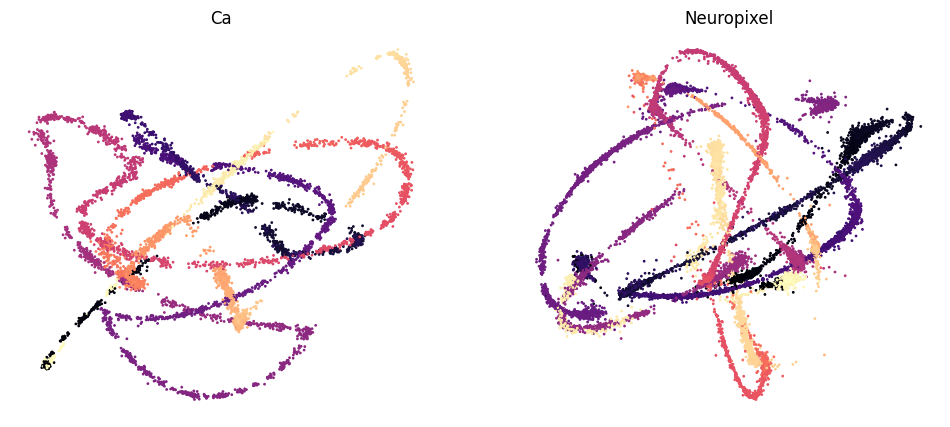

In [166]:
fig = plt.figure(figsize = (12,5))

ax1 = plt.subplot(121)
ax1.set_title('Ca')
ax1.scatter(cebra_ca_emb[:,0], cebra_ca_emb[:,1], cmap = 'magma', c = np.tile(np.arange(900),9), s=1)
ax1.axis('off')

ax2 = plt.subplot(122)
ax2.set_title('Neuropixel')
ax2.scatter(cebra_np_emb[:,0], cebra_np_emb[:,1], cmap = 'magma', c = np.tile(np.repeat(np.arange(900),4),9), s=1)
ax2.axis('off')

## Train CEBRA models (Ca, Neuropixel joint training, 1 frame window) using DINO features as behavior labels

- We use multisession-CEBRA to jointly train Ca and ephys recording, which generates consistent embeddings across the two recording modalities.

In [167]:
joint_loader = cebra.data.ContinuousMultiSessionDataLoader(joint_train, num_steps = train_steps, batch_size = 512, conditional = 'time_delta', time_offset=1)

In [168]:
cebra_joint = multi_session_solver(data_loader = joint_loader, model_architecture = ['offset1-model', 'resample1-model'], 
                 distance = 'cosine', num_hidden_units = 128, output_dimension = 128,
                verbose = True, device = DEVICE, temperature = 1, learning_rate = 3e-4)



In [169]:
cebra_joint.fit(joint_loader)
cebra_joint_embs = _compute_emissions_multi(cebra_joint, joint_train)

pos:  0.0009 neg:  5.9742 total:  5.9751 temperature:  1.0000: 100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [15:31<00:00, 10.73it/s]


(-0.19728029146790504,
 0.15147076919674873,
 -0.1323668047785759,
 0.13234753757715226)

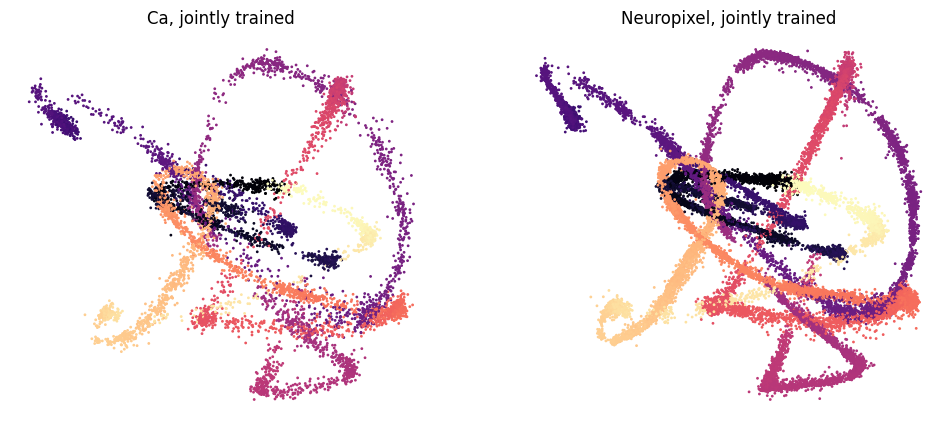

In [170]:
fig = plt.figure(figsize = (12,5))

ax1 = plt.subplot(121)
ax1.set_title('Ca, jointly trained')
ax1.scatter(cebra_joint_embs[0][:,0], cebra_joint_embs[0][:,1], cmap = 'magma', c = np.tile(np.arange(900),9), s=1)
ax1.axis('off')

ax2 = plt.subplot(122)
ax2.set_title('Neuropixel, jointly trained')
ax2.scatter(cebra_joint_embs[1][:,0], cebra_joint_embs[1][:,1], cmap = 'magma', c = np.tile(np.repeat(np.arange(900),4),9), s=1)
ax2.axis('off')

## Decoding movie frame IDs (1 frame window)

- We decode frame IDs (0-900, 30Hz, 30s movie) using CEBRA trained on Neuropixels only, jointly trained CEBRA and mean neural population activity of 1 frame window as a baseline. 
- We use kNN decoder for CEBRA embeddings and kNN & naive Bayes model for baseline decoders. 
- We use the 1-8th repeat as the train set, 9th repeat as the valid set, and the last 10th repeat as test set. 


In [185]:
def allen_frame_id_decode(train_fs, train_labels, test_fs, test_labels, modality = 'neuropixel', decoder = 'knn'):
    
    if modality == 'neuropixel':
        FACTOR = 4
    elif modality == 'ca':
        FACTOR = 1
    
    time_window = 1
    
    def feature_for_one_frame(feature):
        if isinstance(feature, torch.Tensor):
            feature = feature.cpu().numpy()
        return feature.reshape(-1,FACTOR,feature.shape[-1]).mean(axis = 1)
    
    train_fs = feature_for_one_frame(train_fs)
    test_fs = feature_for_one_frame(test_fs)
    
    
    if train_fs is None or test_fs is None:
        return [None], [None], None
    if decoder == 'knn':
        params = np.power(np.linspace(1, 10, 5, dtype=int), 2)
    elif decoder == 'bayes':
        params = np.logspace(-9, 3, 5)
    else:
        raise ValueError('Choose decoder between knn or bayes')
    errs = []

    for n in params:
        if decoder == 'knn':
            train_decoder = KNeighborsClassifier(n_neighbors=n,
                                                     metric='cosine')
        elif decoder == 'bayes':
            train_decoder = GaussianNB(var_smoothing = n)
        train_valid_idx = int(len(train_fs)/9*8)
        train_decoder.fit(train_fs[:train_valid_idx], train_labels[:train_valid_idx])
        pred = train_decoder.predict(train_fs[train_valid_idx:])
        err = train_labels[train_valid_idx:] - pred
        errs.append(abs(err).sum())
    
    if decoder == 'knn':
        test_decoder = KNeighborsClassifier(n_neighbors=params[np.argmin(errs)],
                                                     metric='cosine')
    elif decoder == 'bayes':
        test_decoder = GaussianNB(var_smoothing = params[np.argmin(errs)])

    test_decoder.fit(train_fs, train_labels)
    pred = test_decoder.predict(test_fs)
    frame_errors = pred - test_labels

    def _quantize_acc(frame_diff, time_window=1):

        true = (abs(frame_diff) < (time_window * 30)).sum()

        return true / len(frame_diff) * 100

    quantized_acc = _quantize_acc(frame_errors, time_window)

    return pred, frame_errors, quantized_acc


In [186]:
cebra_joint_test = _compute_emissions_multi(cebra_joint, joint_test)
cebra_np_test = _compute_emissions_single(cebra_np, np_test)

In [187]:
ca_loader_1frame = cebra.data.ContinuousDataLoader(ca_train, num_steps = train_steps, batch_size = 512, conditional = 'time_delta', time_offset =1)
np_loader_1frame = cebra.data.ContinuousDataLoader(np_train, num_steps = train_steps, batch_size = 512, conditional = 'time_delta', time_offset = 1)

cebra_ca_1frame = single_session_solver(data_loader = ca_loader, model_architecture = 'offset1-model', 
                 distance = 'cosine', num_hidden_units = 128, output_dimension = 128,
                verbose = True, device = DEVICE, temperature = 1, learning_rate = 3e-4)

cebra_np_1frame = single_session_solver(data_loader = np_loader, model_architecture = 'resample1-model', 
                 distance = 'cosine', num_hidden_units = 128, output_dimension = 128,
                verbose = True, device = DEVICE, temperature = 1, learning_rate = 3e-4)

joint_loader_1frame = cebra.data.ContinuousMultiSessionDataLoader(joint_train, num_steps = train_steps, batch_size = 512, conditional = 'time_delta', time_offset=1)
cebra_joint_1frame = multi_session_solver(data_loader = joint_loader, model_architecture = ['offset1-model', 'resample1-model'], 
                 distance = 'cosine', num_hidden_units = 128, output_dimension = 128,
                verbose = True, device = DEVICE, temperature = 1, learning_rate = 3e-4)



In [188]:
pred_knn, errs_knn, acc_knn =allen_frame_id_decode(np_train.neural, np.tile(np.arange(900), 9),
                     np_test.neural, np.arange(900), modality = 'neuropixel', decoder = 'knn')

pred_bayes, errs_bayes, acc_bayes=allen_frame_id_decode(np_train.neural, np.tile(np.arange(900), 9),
                     np_test.neural, np.arange(900), modality = 'neuropixel', decoder = 'bayes')

pred_cebra, errs_cebra ,acc_cebra = allen_frame_id_decode(cebra_np_emb, np.tile(np.arange(900), 9), cebra_np_test, np.arange(900), modality = 'neuropixel', decoder = 'knn')

pred_joint_cebra, errs_joint_cebra, acc_joint_cebra = allen_frame_id_decode(cebra_joint_embs[1], np.tile(np.arange(900), 9), cebra_joint_test[1], np.arange(900),modality = 'neuropixel', decoder = 'knn')

In [189]:
print(f'kNN baseline: {acc_knn:.2f}%')
print(f'Bayes baseline: {acc_bayes:.2f}%')
print(f'CEBRA Neuropixel: {acc_cebra:.2f}%')
print(f'joint CEBRA Neuropixel: {acc_joint_cebra:.2f}%')

kNN baseline: 55.56%
Bayes baseline: 67.67%
CEBRA Neuropixel: 81.89%
joint CEBRA Neuropixel: 89.00%


## Consistency across different visual cortical areas

- We train jointly CEBRA-Behavior models using Ca and Neuropixels recordings from different visual cortical areas and compute linear consistencies between the cortical areas. We can observe that intra-area consistency is higher than inter-area consistencies. 


In [290]:
cortex1 = 'VISp'
cortex2 = 'VISrl'

cortex1=cebra.datasets.init(f"allen-movie-one-ca-neuropixel-{cortex1}-disjoint-0-400-train-10-{seed}")
cortex2=cebra.datasets.init(f"allen-movie-one-ca-neuropixel-{cortex2}-disjoint-0-400-train-10-{seed}")

In [291]:
cortex1_loader = cebra.data.ContinuousMultiSessionDataLoader(cortex1, num_steps = 1000, batch_size = 512, conditional = 'time_delta', time_offset=10)
cebra_cortex1 = multi_session_solver(data_loader = cortex1_loader, model_architecture = ['offset10-model', 'resample-model'], 
                 distance = 'cosine', num_hidden_units = 32, output_dimension = 32,
                verbose = True, device = DEVICE, temperature = 1, learning_rate = 3e-4)

cortex2_loader = cebra.data.ContinuousMultiSessionDataLoader(cortex2, num_steps = 1000, batch_size = 512, conditional = 'time_delta', time_offset=10)
cebra_cortex2 = multi_session_solver(data_loader = cortex2_loader, model_architecture = ['offset10-model', 'resample-model'], 
                 distance = 'cosine', num_hidden_units = 32, output_dimension = 32,
                verbose = True, device = DEVICE, temperature = 1, learning_rate = 3e-4)


In [292]:
cebra_cortex1.fit(cortex1_loader)
cebra_cortex2.fit(cortex2_loader)


pos:  0.0295 neg:  6.0520 total:  6.0815 temperature:  1.0000: 100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:21<00:00,  7.05it/s]
pos:  0.0908 neg:  6.1152 total:  6.2060 temperature:  1.0000: 100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:18<00:00,  7.20it/s]


In [294]:
cebra_cortex1_embs = _compute_emissions_multi(cebra_cortex1, cortex1)
cebra_cortex2_embs = _compute_emissions_multi(cebra_cortex2, cortex2)

In [295]:
## A helper function to compute linear consistency
def consistency(feature1, feature2):
    if len(feature1) == 32400:
        feature1 = feature1.reshape(-1, 4, feature1.shape[-1]).mean(axis=1)
    if len(feature2) == 32400:
        feature2 = feature2.reshape(-1, 4, feature2.shape[-1]).mean(axis=1)
    def _linear_fit(a,b):
        lin_model = LinearRegression()
        lin_model.fit(a, b)
        return lin_model.score(a, b)
    return _linear_fit(feature1, feature2), _linear_fit(feature2, feature1)


In [296]:
intra_cortices = consistency(cebra_cortex1_embs[0], cebra_cortex1_embs[1])

In [297]:
inter_cortices = []
for cortex1_emb in cebra_cortex1_embs.values():
    for cortex2_emb in cebra_cortex2_embs.values():
        inter_cortices.extend(consistency(cortex1_emb, cortex2_emb))

In [298]:
print(f"Intra-area: {np.mean(intra_cortices):.2f}")
print(f"Inter-area: {np.mean(inter_cortices):.2f}")

Intra-area: 0.90
Inter-area: 0.60
